# CSE 252B: Computer Vision II, Winter 2024 – Assignment 4

Instructor: Ben Ochoa

Assignment due: Wed, Mar 6, 11:59 PM

**Name: Xiao Nan**

**PID: A69027384**

## Instructions
* Review the academic integrity and collaboration policies on the course
website.
* This assignment must be completed individually.
* All solutions must be written in this notebook.
* Math must be done in Markdown/$\LaTeX$.
* You must show your work and describe your solution.
* Programming aspects of this assignment must be completed using Python in this notebook.
* Your code should be well written with sufficient comments to understand, but there is no need to write extra markdown to describe your solution if it is not explictly asked for.
* This notebook contains skeleton code, which should not be modified (this is important for standardization to facilate efficient grading).
* You may use python packages for basic linear algebra, but you may not use functions that directly solve the problem. If you are uncertain about using a specific package, function, or method, then please ask the instructional staff whether it is allowable.
* **You must submit this notebook as an .ipynb file, a .py file, and a .pdf file on Gradescope.**
    - You may directly export the notebook as a .py file.  You may use [nbconvert](https://nbconvert.readthedocs.io/en/latest/install.html) to convert the .ipynb file to a .py file using the following command
    `jupyter nbconvert --to script filename.ipynb`
    - There are two methods to convert the notebook to a .pdf file.
        - You may first export the notebook as a .html file, then print the web page as a .pdf file.
        - If you have XeTeX installed, then you may directly export the notebook as a .pdf file.  You may use [nbconvert](https://nbconvert.readthedocs.io/en/latest/install.html) to convert a .ipynb file to a .pdf file using the following command
        `jupyter nbconvert --allow-chromium-download --to webpdf filename.ipynb`
    - **You must ensure the contents in each cell (e.g., code, output images, printed results, etc.) are clearly visible, and are not cut off or partially cropped in the .pdf file.**
    - Your code and results must remain inline in the .pdf file (do not move your code to an appendix).
    - **While submitting on gradescope, you must assign the relevant pages in the .pdf file submission for each problem.**
* It is highly recommended that you begin working on this assignment early.

# Problem 1 (Programming): Feature detection (20 points)
Download input data from the course website. The file price_center20.JPG
contains image 1 and the file price_center21.JPG contains image 2.

For each input image, calculate an image where each pixel value is the minor
eigenvalue of the gradient matrix

$N=\left[ \begin{array}{cc}
\sum\limits_w I_x^2 & \sum\limits_w I_x I_y\\
\sum\limits_w I_x I_y & \sum\limits_w I_y^2
\end{array} \right]$

where w is the window about the pixel, and $I_x$ and $I_y$ are the gradient images in
the $x$ and $y$ direction, respectively. Calculate the gradient images using the five-point
central difference operator. Set resulting values that are below a specified
threshold value to zero (hint: calculating the mean instead of the sum in N allows
for adjusting the size of the window without changing the threshold value). Apply
an operation that suppresses (sets to 0) local (i.e., about a window) nonmaximum
pixel values in the minor eigenvalue image. Vary these parameters such that
600–650 features are detected in each image. For resulting nonzero pixel
values, determine the subpixel feature coordinate using the Förstner corner point
operator.

You may use scipy.signal.convolve to perform convolution operation and scipy.ndimage.maximum_filter for NMS operation.

You may either directly use the color images for feature detection, or use the color to grayscale mapping $Y = 0.21263903 R + 0.71516871 G + 0.072192319 B$ to convert the images to grayscale first.

#### Report your final values for:
 * the size of the feature detection window (i.e., the size of the window used to calculate the elements in the gradient matrix N)
 * the minor eigenvalue threshold value
 * the size of the local nonmaximum suppression window
 * the resulting number of features detected (i.e., corners) in each image.

#### Display figures for:
 * minor eigenvalue images before thresholding
 * minor eigenvalue images after thresholding
 * original images with detected features

A typical implementation takes around 30 seconds to run. If yours takes more than 120 seconds, you may lose points.

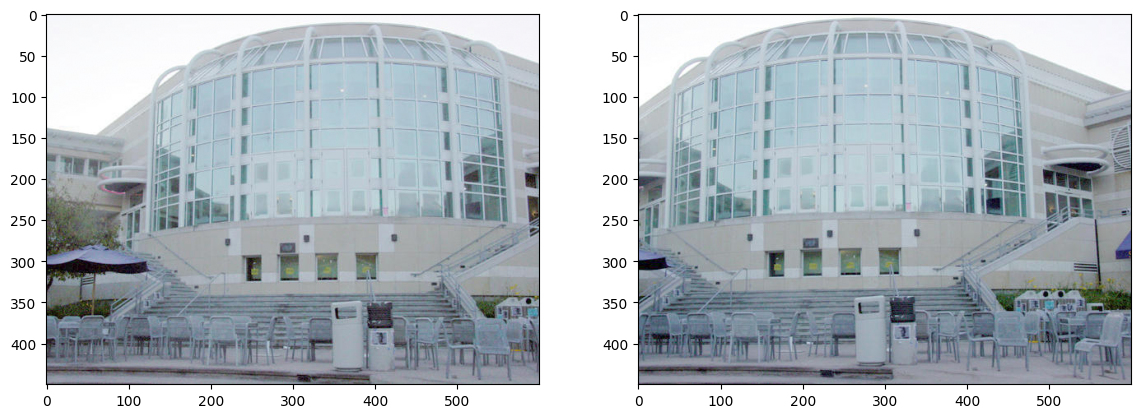

In [29]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

# open the input images
I1 = np.array(Image.open('price_center20.JPG'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.JPG'), dtype='float')/255.

# Display the input images
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(I1)
plt.subplot(1,2,2)
plt.imshow(I2)
plt.show()

In [30]:
from scipy import signal
from scipy import ndimage

def color_to_gray(I):
    # converting to grayscale
    # input:
    # I: RGB image
    # output:
    # I_gray: grayscale image

    conversion = [0.21263903, 0.71516871, 0.072192319]
    I_gray = np.dot(I[...,:3], conversion)
    return I_gray

  
def image_gradient(I):
    # inputs:
    # I is the input image (may be mxn for Grayscale or mxnx3 for RGB)
    #
    # outputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y

    m, n = I.shape[:2]
    k = np.array([[1./12, -8./12, 0, 8./12, -1./12]])
    k = -k # flip kernel for convolution
    Ix = np.zeros((m,n,3))
    Iy = np.zeros((m,n,3))

    """your code here"""
    for channel in range(I.shape[2]):
        # guarantee valid gradients
        Ixc = signal.convolve(I[:,:,channel], k, mode="valid") 
        Iyc = signal.convolve(I[:,:,channel], k.T, mode="valid")

        # zero-pad to maintain size
        Ix[:,:,channel] = np.pad(Ixc, ((0, 0), (2, 2)), 'constant', constant_values=0) 
        Iy[:,:,channel] = np.pad(Iyc, ((2, 2), (0, 0)), 'constant', constant_values=0)
    return Ix, Iy

def minor_eigenvalue_image(Ix, Iy, w):
    # Calculate the minor eigenvalue image J
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    #
    # outputs:
    # J0 is the mxn minor eigenvalue image of N before thresholding

    m, n = Ix.shape[:2]

    # pad to align
    pad_size = w//2

    # compute quadratics
    Ix2 = Ix*Ix
    Ix2 = np.sum(Ix2, axis=2)
    Ixy = Ix*Iy
    Ixy = np.sum(Ixy, axis=2)
    Iy2 = Iy*Iy
    Iy2 = np.sum(Iy2, axis=2)
    
    #Calculate your minor eigenvalue image J0.
    J0 = np.zeros((m,n))
    for i in range(pad_size, m-pad_size):
        for j in range(pad_size, n-pad_size):
            M = np.array([[np.sum(Ix2[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1]),
                                   np.sum(Ixy[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1])],
                                   [np.sum(Ixy[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1]),
                                   np.sum(Iy2[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1])]])
            Tr = np.trace(M)
            Det = 4*np.linalg.det(M)
            Delta = max(0, Tr*Tr - Det)
            J0[i,j] = (0.5) * (Tr - np.sqrt(Delta))   

    return J0

def nms(J, w_nms):
    # Apply nonmaximum supression to J using window w_nms
    #
    # inputs:
    # J is the minor eigenvalue image input image after thresholding
    # w_nms is the size of the local nonmaximum suppression window
    #
    # outputs:
    # J2 is the mxn resulting image after applying nonmaximum suppression
    #

    J2 = J.copy()
    J = ndimage.maximum_filter(J, size=w_nms)
    J2[J2 < J] = 0
    return J2

def forstner_corner_detector(Ix, Iy, w, t, w_nms):
    # Calculate the minor eigenvalue image J
    # Threshold J
    # Run non-maxima suppression on the thresholded J
    # Gather the coordinates of the nonzero pixels in J
    # Then compute the sub pixel location of each point using the Forstner operator
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    # t is the minor eigenvalue threshold
    # w_nms is the size of the local nonmaximum suppression window
    #
    # outputs:
    # C is the number of corners detected in each image
    # pts is the 2xC array of coordinates of subpixel accurate corners
    #     found using the Forstner corner detector
    # J0 is the mxn minor eigenvalue image of N before thresholding
    # J1 is the mxn minor eigenvalue image of N after thresholding
    # J2 is the mxn minor eigenvalue image of N after thresholding and NMS

    m, n = Ix.shape[:2]
    J0 = np.zeros((m,n))

    #Calculate your minor eigenvalue image J0 and its thresholded version J1.
    J0 = minor_eigenvalue_image(Ix, Iy, w)
    J1 = J0.copy()
    # print(J1)
    J1[J1 < t] = 0


    #Run non-maxima suppression on your thresholded minor eigenvalue image.
    J2 = nms(J1, w_nms)

    #Detect corners. (global thresholding ignored)
    C = np.sum(J2!=0)
    coords = J2.nonzero()
    print("number of cornors detected: {}".format(C))
    # print(np.max(coords[0]), np.max(coords[1]))

    # compute quadratics
    Ix2 = Ix*Ix
    Ix2 = np.sum(Ix2, axis=2)
    Ixy = Ix*Iy
    Ixy = np.sum(Ixy, axis=2)
    Iy2 = Iy*Iy
    Iy2 = np.sum(Iy2, axis=2)
    x = np.linspace(0, m-1, m)
    y = np.linspace(0, n-1, n)
    xv, yv = np.meshgrid(x, y, indexing='ij') # matrix indexing
    # print(xv.shape, Ix2.shape, yv.shape, Ixy.shape)
    # print(xv, Ix2, yv, Ixy)
    b1 = xv*Ix2 + yv*Ixy
    b2 = xv*Ixy + yv*Iy2
    pad_size = w//2 # grad window size = cornor search window size

    # iterate to get cornors in the patches
    # Done: Find non-zero corner-like window centers and compute cornors' locations
    pts = np.zeros((2, C))
    cnt = 0
    for i, j in zip(coords[0], coords[1]):
        x_left_lim, x_right_lim = max(0, i-pad_size), min(n, i+pad_size+1)
        y_up_lim, y_down_lim = max(0, j-pad_size), min(n, j+pad_size+1)
        A = np.array([[np.sum(Ix2[x_left_lim:x_right_lim, y_up_lim:y_down_lim]),
                    np.sum(Ixy[x_left_lim:x_right_lim, y_up_lim:y_down_lim])],
                    [np.sum(Ixy[x_left_lim:x_right_lim, y_up_lim:y_down_lim]),
                    np.sum(Iy2[x_left_lim:x_right_lim, y_up_lim:y_down_lim])]])
        b = np.array([[np.sum(b1[x_left_lim:x_right_lim, y_up_lim:y_down_lim])],
                    [np.sum(b2[x_left_lim:x_right_lim, y_up_lim:y_down_lim])]])
        x = np.dot(np.linalg.inv(A),b)
        pts[:, cnt] = x[::-1,0]
        cnt += 1
    return C, pts, J0, J1, J2


# feature detection
def run_feature_detection(I, w, t, w_nms):
    Ix, Iy = image_gradient(I)
    C, pts, J0, J1, J2 = forstner_corner_detector(Ix, Iy, w, t, w_nms)
    return C, pts, J0, J1, J2

In [31]:
# ImageGradient() unit test
def check_values(I, target):
    eps = 1e-8  # Floating point error threshold
    I = I[2:-2, 2:-2]  # Ignore border values
    valid = np.all((I < target + eps) & (I > target - eps))
    print(f'Image is all equal to {target} +/- {eps}: {valid}')

def gray_to_RGB(I):
    h, w = I.shape
    I = np.expand_dims(I, axis=-1)
    return np.broadcast_to(I, (h, w, 3))

rampx = np.array(Image.open('rampx.png'), dtype='float')
rampy = np.array(Image.open('rampy.png'), dtype='float')

# If you are using grayscale images in ImageGradient(), comment out these lines
rampx = gray_to_RGB(rampx)
rampy = gray_to_RGB(rampy)

# rampx_Ix should be all ones, rampx_Iy should be all zeros (to floating point error)
rampx_Ix, rampx_Iy = image_gradient(rampx)
check_values(rampx_Ix, 1)
check_values(rampx_Iy, 0)

# rampy_Ix should be all zeros, rampx_Iy should be all ones (to floating point error)
rampy_Ix, rampy_Iy = image_gradient(rampy)
check_values(rampy_Ix, 0)
check_values(rampy_Iy, 1)

Image is all equal to 1 +/- 1e-08: True
Image is all equal to 0 +/- 1e-08: True
Image is all equal to 0 +/- 1e-08: True
Image is all equal to 1 +/- 1e-08: True


number of cornors detected: 612
number of cornors detected: 632
took 16.366483 secs
C1=612, C2=632


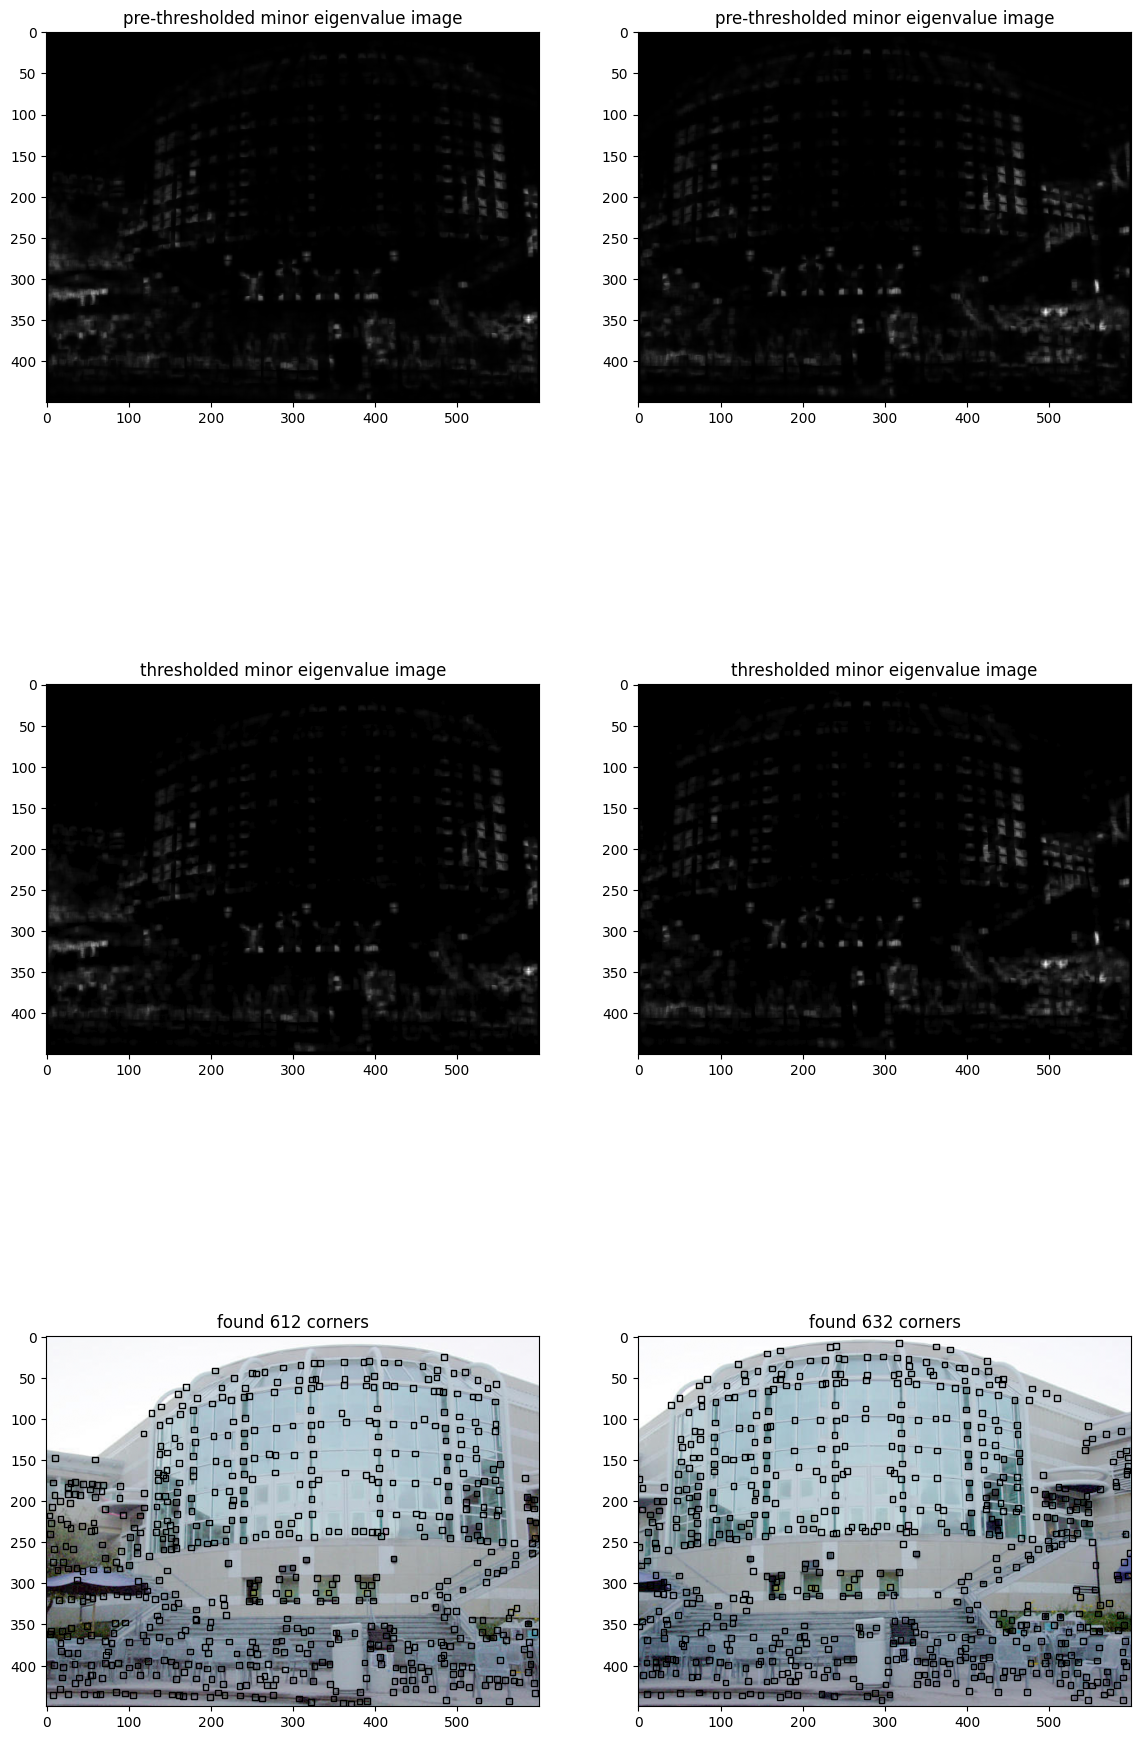

In [32]:
# input images
I1 = np.array(Image.open('price_center20.JPG'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.JPG'), dtype='float')/255.

# parameters to tune
w = 7
t = 0.06
w_nms = 9

tic = time.time()
# run feature detection algorithm on input images
C1, pts1, J1_0, J1_1, J1_2 = run_feature_detection(I1, w, t, w_nms)
C2, pts2, J2_0, J2_1, J2_2 = run_feature_detection(I2, w, t, w_nms)
toc = time.time() - tic

print('took %f secs'%toc)
print("C1={}, C2={}".format(C1, C2))

# display results
plt.figure(figsize=(14,24))

# show pre-thresholded minor eigenvalue images
plt.subplot(3,2,1)
plt.imshow(J1_0, cmap='gray')
plt.title('pre-thresholded minor eigenvalue image')
plt.subplot(3,2,2)
plt.imshow(J2_0, cmap='gray')
plt.title('pre-thresholded minor eigenvalue image')

# show thresholded minor eigenvalue images
plt.subplot(3,2,3)
plt.imshow(J1_1, cmap='gray')
plt.title('thresholded minor eigenvalue image')
plt.subplot(3,2,4)
plt.imshow(J2_1, cmap='gray')
plt.title('thresholded minor eigenvalue image')

# show corners on original images
ax = plt.subplot(3,2,5)
plt.imshow(I1)
for i in range(C1): # draw rectangles of size w around corners
    x,y = pts1[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts1[0,:], pts1[1,:], '.b') # display subpixel corners
plt.title('found %d corners'%C1)

ax = plt.subplot(3,2,6)
plt.imshow(I2)
for i in range(C2):
    x,y = pts2[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts2[0,:], pts2[1,:], '.b')
plt.title('found %d corners'%C2)

plt.show()

#### Final values for parameters
* w = 7
* t = 0.06
* w_nms = 9
* C1 = 612
* C2 = 632

## Problem 2 (Programming): Feature matching (15 points)
Determine the set of one-to-one putative feature correspondences by performing
a brute-force search for the greatest correlation coefficient value (in the range
[-1, 1]) between the detected features in image 1 and the detected features in
image 2. Only allow matches that are above a specified correlation coefficient
threshold value (note that calculating the correlation coefficient allows for adjusting
the size of the matching window without changing the threshold value).
Further, only allow matches that are above a specified distance ratio threshold
value, where distance is measured to the next best match for a given feature.
Vary these parameters such that 160-240 putative feature correspondences are
established. Optional: constrain the search to coordinates in image 2 that are
within a proximity of the detected feature coordinates in image 1. The proximity is calculated using the subpixel coordinates of the detected feature coordinates in image 1 and image 2.  Given $(x_1, y_1)$ in image 1 and $(x_2, y_2)$ in image 2, you can think of a square with side length $p$, centered at $(x_2, y_2)$. Then, $(x_1, y_1)$ is within the proximity window if it lies inside that square.

Use the following formula to calculate the correlation coefficient (normalized cross correlation) between two image windows $I_1$ and $I_2$:
$$\frac{\sum_{x, y}\left[ I_1(x, y) - \overline{I_1} \right] \left[ I_2(x, y) - \overline{I_2} \right] }{\sqrt{\sum_{x, y}\left[ I_1(x, y) - \overline{I_1} \right]^2 \cdot \sum_{x, y}\left[ I_2(x, y) - \overline{I_2} \right]^2}}$$

where $I(x, y)$ is the pixel value of $I$ at $(x, y)$ and $\overline{I}$ is the mean value of $I$.

**Note: You must center each window at the sub-pixel corner coordinates while computing normalized cross correlation, i.e., you must use bilinear interpolation to compute the pixel values at non-integer coordinates; otherwise, you will lose points.**

#### Report your final values for:
* the size of the matching window
* the correlation coefficient threshold
* the distance ratio threshold
* the size of the proximity window (if used)
* the resulting number of putative feature correspondences (i.e., matched features)

#### Display figures for:
* pair of images, where the matched features in each of the images are indicated by a square window about the feature.

(You must use original (color) images to the draw boxes and correspondence lines)

A typical implementation takes around 10 seconds to run. If yours takes more than 120 seconds, you may lose points.


In [33]:
from scipy.interpolate import RegularGridInterpolator

def bilinear_interpolation1(pts,I_gray,w):
    # inputs:
    # pts: center points
    # I_gray: grayscale converted input image
    # w: window size
    #
    # output:
    # Interpolated pixel values for the corner windows

    half_win = w//2
    I_gray = np.pad(I_gray,pad_width=half_win)
    x = np.linspace(0,I_gray.shape[1]-1,I_gray.shape[1])
    y = np.linspace(0,I_gray.shape[0]-1,I_gray.shape[0])
    interp = RegularGridInterpolator((y, x),I_gray, bounds_error=False, fill_value=None)

    windows = []

    for c in range(pts.shape[1]):
    #   print(pts[0][c]-half_win,pts[0][c]+half_win+1,2*half_win-1)
      xx = np.linspace(pts[0][c]-half_win,pts[0][c]+half_win+1,2*half_win-1)
      yy = np.linspace(pts[1][c]-half_win,pts[1][c]+half_win+1,2*half_win-1)
      X, Y = np.meshgrid(xx, yy, indexing='ij')
      w1 = interp((Y,X)) # interpolate on a floating-point window
      windows.append(w1)

    return windows

def get_corr_coeff(wind1_curr, wind2_curr):
    # get correlation coefficient between windows 1 and 2 based on greyscale computations
    I1mean, I2mean = np.mean(wind1_curr), np.mean(wind2_curr)
    shifted_wind1, shifted_wind2 = wind1_curr-I1mean, wind2_curr-I2mean
    corr = np.sum(shifted_wind1 * shifted_wind2) / np.sqrt(np.sum(shifted_wind1**2) * np.sum(shifted_wind2**2))
    assert(-1.0 <= corr <= 1.0)
    return corr

def compute_ncc(I1, I2, pts1, pts2, w, p):
    # compute the normalized cross correlation between image patches I1, I2
    # result should be in the range [-1,1]
    #
    # Do ensure that windows are centered at the sub-pixel co-ordinates
    #      while computing normalized cross correlation.
    #
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # p is the size of the proximity window
    #
    # output:
    # normalized cross correlation matrix of scores between all windows in
    #    image 1 and all windows in image 2
    #
    
    # get cross correlation matrix
    l1, l2 = pts1.shape[1], pts2.shape[1]
    I1_gray, I2_gray = color_to_gray(I1), color_to_gray(I2)
    wind1, wind2 = bilinear_interpolation1(pts1, I1_gray, w), bilinear_interpolation1(pts2, I2_gray, w)
    scores = np.zeros((l1, l2))
    for i in range(l1):
        for j in range(l2):
            pt1, pt2 = pts1[:, i], pts2[:, j]
            if (np.linalg.norm(pt1 - pt2) < p):
                wind1_curr, wind2_curr = wind1[i], wind2[j]
                corr = get_corr_coeff(wind1_curr, wind2_curr)
                scores[i, j] = corr
            else:
                scores[i, j] = -1.0
    return scores


def perform_match(scores, t, d):
    # perform the one-to-one correspondence matching on the correlation coefficient matrix
    #
    # inputs:
    # scores is the NCC matrix
    # t is the correlation coefficient threshold
    # d distance ration threshold
    #
    # output:
    # 2xM array of the feature coordinates in image 1 and image 2,
    # where M is the number of matches.
    ind_I1 = []
    ind_I2 = []
    mask = np.ones(scores.shape)
    masked_scores = scores * mask
    while (np.max(masked_scores) > t):
        # get best and the next best correlation coefficients' values
        max_index = np.unravel_index(np.argmax(masked_scores, axis=None), masked_scores.shape)
        max_val = scores[max_index]
        scores[max_index] = -1
        # print(np.max(scores[max_index[0], :]), np.max(scores[:, max_index[1]]))
        next_best_val = np.max([np.max(scores[max_index[0], :]), np.max(scores[:, max_index[1]])])
        scores[max_index] = max_val

        # if best value is much better than the second best: keep the best val
        if ((1 - max_val) < ((1 - next_best_val) * d)): 
            ind_I1.append(max_index[0])
            ind_I2.append(max_index[1])
        
        # remove matched windows from considerations 
        mask[max_index[0], :] = 0
        mask[:, max_index[1]] = 0
        masked_scores = scores * mask
    print("The number of matches found: {}".format(len(ind_I1)))
    return np.array([ind_I1, ind_I2])


def run_feature_matching(I1, I2, pts1, pts2, w, t, d, p):
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the size of the proximity window
    #
    # outputs:
    # inds is a 2xk matrix of matches where inds[0,i] indexs a point pts1
    #     and inds[1,i] indexs a point in pts2, where k is the number of matches

    scores = compute_ncc(I1, I2, pts1, pts2, w, p)
    inds = perform_match(scores, t, d)
    return inds

The number of matches found: 186
took 3.541630 secs


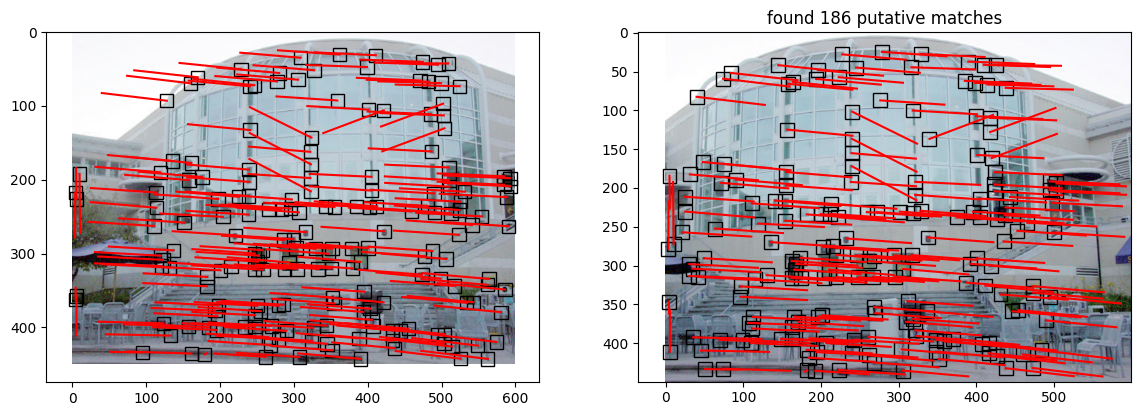

unique points in image 1: 186
unique points in image 2: 186


In [82]:
# parameters to tune
w = 18
t = 0.88
d = 0.82
p = 100

tic = time.time()
# run the feature matching algorithm on the input images and detected features
inds = run_feature_matching(I1, I2, pts1, pts2, w, t, d, p)
toc = time.time() - tic

print('took %f secs'%toc)

# create new matrices of points which contain only the matched features
match1 = pts1[:,inds[0,:].astype('int')]
match2 = pts2[:,inds[1,:].astype('int')]

# display the results
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('found %d putative matches'%match1.shape[1])
for i in range(match1.shape[1]):
    x1,y1 = match1[:,i]
    x2,y2 = match2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

# test 1-1
print('unique points in image 1: %d'%np.unique(inds[0,:]).shape[0])
print('unique points in image 2: %d'%np.unique(inds[1,:]).shape[0])

#### Final values for parameters
* w = 18
* t = 0.88
* d = 0.82
* p = 100 
* num_matches = 186

## Problem 3 (Programming): Outlier Rejection (15 points)
The resulting set of putative point correspondences should contain both inlier
and outlier correspondences (i.e., false matches). Determine the set of inlier point
correspondences using the M-estimator Sample Consensus (MSAC) algorithm,
where the maximum number of attempts to find a consensus set is determined
adaptively. For each trial, you must use the 4-point algorithm (as described in
lecture) to solve for the planar projective transformation from the 2D points in
image 1 to the 2D points in image 2. Calculate the (squared) Sampson error as a
first order approximation to the geometric error. There must be at least **150 inlier correspondences**.

hint: this problem has codimension 2

#### Report your values for:
 * the probability $p$ that as least one of the random samples does not contain any outliers
 * the probability $\alpha$ that a given point is an inlier
 * the resulting number of inliers
 * the number of attempts to find the consensus set
 * the tolerance for inliers
 * the cost threshold

#### Display figures for:
* pair of images, where the inlier features in each of the images are indicated by a square window about the feature and a line segment is drawn from the feature to the coordinates of the corresponding feature in the other image


Final minimal cost after 4 (max trial 3.50483052168722) iterations: [217.50133057]
took 0.066525 secs
4 iterations
inlier count:  172
inliers:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185]
MSAC Cost=217.501330569
H_MSAC =
[[ 1.10041494e-02 -5.06556939e-05 -9.79704762e-01]
 [ 3.91656604e-

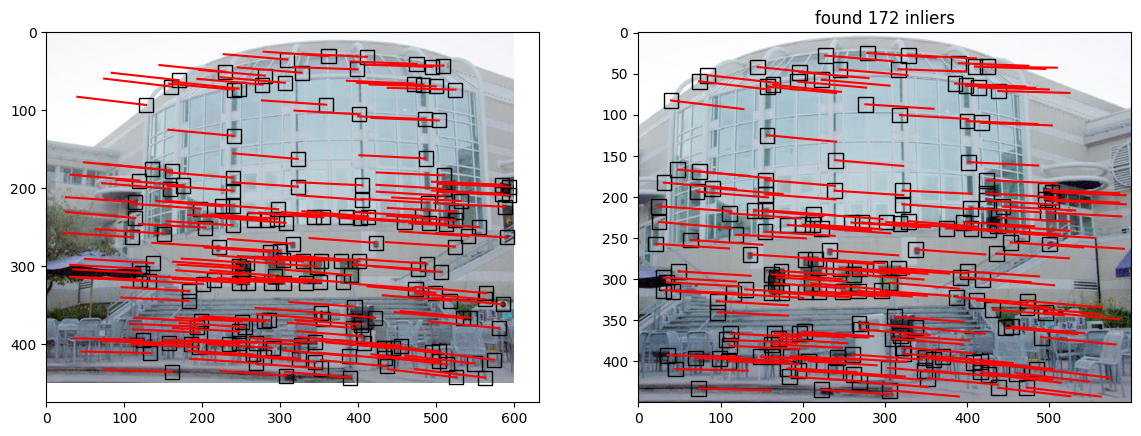

p = 
0.99
alpha = 
0.95
tolerance = 
5.991464547107979
threshold = 
50
num_inliers = 
172
num_attempts = 
4


In [83]:
from scipy.stats import chi2
import time

def display_results(H, title):
    print(title+' =')
    print (H/np.linalg.norm(H)*np.sign(H[-1,-1]))

def homogenize(x):
    # converts points from inhomogeneous to homogeneous coordinates
    return np.vstack((x,np.ones((1,x.shape[1]))))

def dehomogenize(x):
    # converts points from homogeneous to inhomogeneous coordinates
    return x[:-1]/x[-1]

def compute_MSAC_cost(H,x1,x2,tol,error):
    # Inputs:
    # x1 - 2D points in image 1
    # x2 - 2D points in image 2
    # H - planar projective transformation matrix
    # tol - tolerance for establishing datum/model compatibility
    # error - pre-computed projection error
    #
    # Output:
    # cost - Squared sampson error

    # n = x1.shape[1]
    # A = np.zeros(n, 9)
    # x1_homo, x2_homo = homogenize(x1), homogenize(x2)
    # for j in range(n):
    #     A[j, :] = np.kron(x2_homo[:, j], x1_homo[:, j])

    inlier_ind = []
    cost = 0
    count = x1.shape[1]
    for n in range(count):
        if (error[n] <= tol):
            cost += error[n]
            inlier_ind.append(n)
        else:
            cost += tol
    return cost, inlier_ind

np.random.seed(38)
def choose_random_column_indices(array_2d, num_columns_to_choose):
    """
    Chooses a random sample of columns from a 2D NumPy array.
    
    Parameters:
        array_2d (ndarray): The input 2D NumPy array.
        num_columns_to_choose (int): The number of columns to choose randomly.
        
    Returns:
        random_column_indices: Indices of the randomly chosen columns.
    """
    # Number of columns in the array
    num_columns = array_2d.shape[1]
    # Randomly choose column indices
    random_column_indices = np.random.choice(num_columns, size=num_columns_to_choose, replace=False)
    return random_column_indices

def solveInvHSB(pts):
    # solve the standard basis transform matrix
    # Input: pts is a 3*4 array of points at a given image plane
    pts = homogenize(pts)
    A = np.hstack([pts[:, 0][..., None], pts[:, 1][..., None], pts[:, 2][..., None]])
    b = pts[:, 3]
    # print(A.shape)
    lamb = np.linalg.inv(A) @ b
    HSBinv = A * lamb
    return HSBinv

def sampson_error(H, pts1_samp, pts2_samp):
    # compute sampson error given samples and H
    pts1_samp_inhomo = pts1_samp
    pts2_samp_inhomo = pts2_samp
    n = pts1_samp.shape[1]
    eps = np.zeros((2*n,1))
    J = np.zeros((2*n,4))
    sampSqr = np.zeros((n,1))
    for j in range(n):
        pt1, pt2 = pts1_samp_inhomo[:, j], pts2_samp_inhomo[:, j]
        xj, yj, xjprime, yjprime = pt1[0], pt1[1], pt2[0], pt2[1]
        h11, h12, h13, h21, h22, h23, h31, h32, h33 = H[0,0], H[0,1], H[0,2], H[1,0], H[1,1], H[1,2], H[2,0], H[2,1], H[2,2]
        eps[2*j, :] = -(xj*h21+yj*h22+h23) + yjprime*(xj*h31+yj*h32+h33)
        eps[2*j+1, :] = (xj*h11+yj*h12+h13) - xjprime*(xj*h31+yj*h32+h33)
        J[2*j, :] = np.array([-h21+yjprime*h31, -h22+yjprime*h32, 0, xj*h31+yj*h32+h33])
        J[2*j+1, :] = np.array([h11-xj*h31, h12-xj*h32, -(xj*h31+yj*h32+h33), 0])
        epsi, Ji = eps[2*j:2*j+2, :], J[2*j:2*j+2, :]
        sampSqr[j, :] = epsi.T @ np.linalg.inv(Ji@Ji.T) @ epsi
    return sampSqr

def determine_inliers(pts1, pts2, thresh, tol, p):
    # Inputs:
    #    pts1 - matched feature correspondences in image 1
    #    pts2 - matched feature correspondences in image 2
    #    thresh - cost threshold
    #    tol - reprojection error tolerance
    #    p - probability that as least one of the random samples does not contain any outliers
    #
    # Output:
    #    consensus_min_cost - final cost from MSAC
    #    consensus_min_cost_model - planar projective transformation matrix H
    #    inliers - list of indices of the inliers corresponding to input data
    #    trials - number of attempts taken to find consensus set
    trials = 0
    max_trials = np.inf
    consensus_min_cost = np.inf
    consensus_min_cost_model = np.zeros((3,3))
    n = pts1.shape[1]
    s = 4 # sample size = 4
    trials = 0
    inliers = [0]*39

    while ((trials < max_trials) and (consensus_min_cost > thresh)): # "for" loop's number of rounds executing cannot be updated. So use "while" instead
        samp_inds = choose_random_column_indices(pts1, s)
        pts1_samp = pts1[:, samp_inds]
        pts2_samp = pts2[:, samp_inds]

        # solve H: 2d projective transformation matrix
        HSBinv1, HSBinv2 = solveInvHSB(pts1_samp), solveInvHSB(pts2_samp)
        H = HSBinv2 @ np.linalg.inv(HSBinv1)

        # evaluate sampson's error for H
        error = sampson_error(H, pts1, pts2)

        # evaluate and update MSAC sampson's cost
        cost, inlier_ind = compute_MSAC_cost(H, pts1, pts2, tol, error)
        if (cost < consensus_min_cost):
            consensus_min_cost = cost
            consensus_min_cost_model = H
            inliers = inlier_ind
            w = len(inlier_ind) / n
            max_trials = np.log(1-p) / np.log(1-(w**s))
        trials += 1

    print("Final minimal cost after {} (max trial {}) iterations: {}".format(trials, max_trials, consensus_min_cost))
    return consensus_min_cost, consensus_min_cost_model, inliers, trials



# MSAC parameters
codim = 2
thresh = 50
p = 0.99
alpha = 0.95
tol = chi2.ppf(alpha, codim) * 1

tic=time.time()

cost_MSAC, H_MSAC, inliers, trials = determine_inliers(match1, match2, thresh, tol, p)

# choose just the inliers
xin1 = match1[:,inliers]
xin2 = match2[:,inliers]

toc=time.time()
time_total=toc-tic

# display the results
print('took %f secs'%time_total)
print('%d iterations'%trials)
print('inlier count: ',len(inliers))
print('inliers: ',inliers)
print('MSAC Cost=%.9f'%cost_MSAC)
display_results(H_MSAC, 'H_MSAC')

# display the figures
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('found %d inliers'%xin1.shape[1])
for i in range(xin1.shape[1]):
    x1,y1 = xin1[:,i]
    x2,y2 = xin2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

# display the results
print('p = ')
print(p)
print('alpha = ')
print(alpha)
print('tolerance = ')
print(tol)
print('threshold = ')
print(thresh)
print('num_inliers = ')
print(len(inliers))
print('num_attempts = ')
print(trials)

## Problem 4 (Programming): Linear Estimate (15 points)
  Estimate the planar projective transformation $\mathtt{H}_\text{DLT}$
  from the resulting set of inlier correspondences using the direct
  linear transformation (DLT) algorithm (with data normalization).
  You must express $\boldsymbol{\mathrm{x}}'_i = \mathtt{H} \boldsymbol{\mathrm{x}}_i$ as
  $[\boldsymbol{\mathrm{x}}'_i]^\perp \mathtt{H} \boldsymbol{\mathrm{x}}_i = \boldsymbol{0}$ (not
  $\boldsymbol{\mathrm{x}}'_i \times \mathtt{H} \boldsymbol{\mathrm{x}}_i = \boldsymbol{0}$), where
  $[\boldsymbol{\mathrm{x}}'_i]^\perp \boldsymbol{\mathrm{x}}'_i = \boldsymbol{0}$, when forming the
  solution. Return $\mathtt{H}_\text{DLT}$, scaled such that
  $\lVert\mathtt{H}_\text{DLT}\rVert_\text{Fro} = 1$

In [84]:
def data_normalize(pts):
    # Input:
    # pts - 2D scene points
    # Outputs:
    # pts - data normalized points
    # T - corresponding transformation matrix
    dim = pts.shape[0]
    pts_homo = homogenize(pts)
    mux, muy, varx, vary = np.mean(pts[0, :]), np.mean(pts[1, :]), np.var(pts[0, :]), np.var(pts[1, :])
    s = np.sqrt(2/(varx + vary))
    T = np.array([[s, 0, -s*mux], [0, s, -s*muy], [0, 0, 1]])
    pts_tr_homo = T @ pts_homo # perform transformation
    pts_tr = dehomogenize(pts_tr_homo)
    return pts_tr, T

def Normalize(pts):
    # data normalization of n dimensional pts
    #
    # Input:
    #    pts - is in inhomogeneous coordinates
    # Outputs:
    #    pts - data normalized points
    #    T - corresponding transformation matrix
    
    """your code here"""
    num_axes = pts.shape[0]
    var = np.var(pts, 1).reshape(-1, 1)
    mean = np.mean(pts,1).reshape(-1, 1)
    var_sum = np.sum(var)
    s = np.sqrt(num_axes / var_sum)
        
    T = np.eye(pts.shape[0]+1)
    for i in range(T.shape[0]-1):
        T[i,i] = s
        T[i,-1] = -mean[i] * s

    points_homogenous = homogenize(pts)
    for i in range(pts.shape[1]):
        points_homogenous[:,i] = np.matmul(T, points_homogenous[:,i])
    return points_homogenous, T


def compute_sampson_cost(H,x1,x2):
    # Inputs:
    # x1 - 2D points in image 1
    # x2 - 2D points in image 2
    # H - planar projective transformation matrix
    #
    # Output:
    # cost - Squared sampson error
    # compute sampson error given samples and H
    n = x1.shape[1]
    eps = np.zeros((2*n,1))
    J = np.zeros((2*n,4))
    sampSqr = np.zeros((n,1))
    for j in range(n):
        pt1, pt2 = x1[:, j], x2[:, j]
        xj, yj, xjprime, yjprime = pt1[0], pt1[1], pt2[0], pt2[1]
        h11, h12, h13, h21, h22, h23, h31, h32, h33 = H[0,0], H[0,1], H[0,2], H[1,0], H[1,1], H[1,2], H[2,0], H[2,1], H[2,2]
        eps[2*j, :] = -(xj*h21+yj*h22+h23) + yjprime*(xj*h31+yj*h32+h33)
        eps[2*j+1, :] = (xj*h11+yj*h12+h13) - xjprime*(xj*h31+yj*h32+h33)
        J[2*j, :] = np.array([-h21+yjprime*h31, -h22+yjprime*h32, 0, xj*h31+yj*h32+h33])
        J[2*j+1, :] = np.array([h11-xj*h31, h12-xj*h32, -(xj*h31+yj*h32+h33), 0])
        epsi, Ji = eps[2*j:2*j+2, :], J[2*j:2*j+2, :]
        sampSqr[j, :] = epsi.T @ np.linalg.inv(Ji@Ji.T) @ epsi
    return sampSqr

def get_left_null_space(x):
    """
    get left null space of pt x
    input:  x - 2D homogeneous image points (3)
    output:  x_perp - null space of the points (2*3)
    """
    # print(x.shape)
    x_norm = np.linalg.norm(x)
    e1 = np.eye(3)[:, 0]
    sign = np.sign(x[0])
    v = x + sign * x_norm * e1
    Hv = np.eye(3) - 2 * ((np.outer(v, v)) / (v.T @ v))
    x_perp = Hv[1:, :]
    return x_perp

def estimate_2D_projective_transformation_linear(x1, x2, normalize=True):
    # Inputs:
    #    x1 - inhomogeneous inlier correspondences in image 1
    #    x2 - inhomogeneous inlier correspondences in image 2
    #    normalize - if True, apply data normalization to x1 and x2
    #
    # Outputs:
    #    H - the DLT estimate of the planar projective transformation
    #    cost - Sampson cost for the above DLT Estimate H. Assume points in image 1 as scene points.

    # data normalization
    if normalize:
        x1_norm, T1 = data_normalize(x1)
        x2_norm, T2 = data_normalize(x2)
        print('normalize')
    else:
        x1_norm = x1
        x2_norm = x2
    x1_homo = homogenize(x1_norm)
    x2_homo = homogenize(x2_norm)

    # estimate planar projection matrix
    n = x1.shape[1]
    A = np.zeros((2*n, 9))
    for j in range(n):
        x1j, x2j = x1_homo[:, j], x2_homo[:, j]
        x2j_perp = get_left_null_space(x2j)
        A[2*j, :] = np.kron(x2j_perp[0, :], x1j)
        A[2*j+1, :] = np.kron(x2j_perp[1, :], x1j)
    _ , _, Vt = np.linalg.svd(A)
    H = Vt[-1, :]
    H = np.reshape(H, (3,3))

    # data denormalize
    if normalize:
        H = np.linalg.inv(T2) @ H @ T1
        print('denormalize')

    H = H / np.linalg.norm(H)
    cost = compute_sampson_cost(H, x1, x2)
    cost = np.sum(cost) # use sum of the squared sampson's cost as the total cost
    return H, cost



# compute the linear estimate without data normalization
print('Running DLT without data normalization')
time_start=time.time()
H_DLT,cost = estimate_2D_projective_transformation_linear(xin1, xin2, normalize=False)
time_total=time.time()-time_start
# display the results
print('took %f secs'%time_total)
print('Cost=%.9f'%cost)


# compute the linear estimate with data normalization
print ('Running DLT with data normalization')
time_start=time.time()
H_DLT, cost = estimate_2D_projective_transformation_linear(xin1, xin2, normalize=True)
time_total=time.time()-time_start
# display the results
print('took %f secs'%time_total)
print('Cost=%.9f'%cost)

# display your H_DLT, scaled with its frobenius norm
display_results(H_DLT, 'H_DLT')

Running DLT without data normalization
took 0.041122 secs
Cost=44.166962899
Running DLT with data normalization
normalize
denormalize
took 0.029329 secs
Cost=43.401898342
H_DLT =
[[ 1.09743803e-02 -2.07262467e-05 -9.85058965e-01]
 [ 3.12125044e-04  1.06850992e-02 -1.71228782e-01]
 [ 1.22279777e-06  7.77686799e-08  1.02387715e-02]]


## Problem 5 (Programming): Nonlinear Estimate (45 points)
 Use $\mathtt{H}_\text{DLT}$ and the Sampson corrected points (in image 1) as an initial estimate to an iterative estimation method,
  specifically the sparse Levenberg-Marquardt algorithm, to
  determine the Maximum Likelihood estimate of the planar projective
  transformation that minimizes the reprojection error.  You must
  parameterize the planar projective transformation matrix and the
  homogeneous 2D scene points that are being adjusted using the
  parameterization of homogeneous vectors.
  
  Report the initial cost (i.e. cost at iteration 0) and the cost at the end
  of each successive iteration. Show the numerical values for the final
  estimate of the planar projective transformation matrix $\mathtt{H}_\text{LM}$, scaled
  such that $\lVert\mathtt{H}_\text{LM}\rVert_\text{Fro} = 1$.

In [87]:
# Note that np.sinc is different than defined in class
def sinc(x):
    # Returns a scalar valued sinc value
    if (x==0):
        return 1
    else:
        return np.sin(x) / x

def d_sinc(x):
    if (x==0):
        return 0
    else:
        return (np.cos(x) / x) - (np.sin(x) / (x**2))
    
def skew(w):
    # Returns the skew-symmetrix represenation of a vector
    w_skew = np.zeros((3, 3))
    w_skew[0, 1], w_skew[1, 0] = -w[2], w[2] 
    w_skew[0, 2], w_skew[2, 0] = w[1], -w[1] 
    w_skew[1, 2], w_skew[2, 1] = -w[0], w[0] 
    return w_skew

def parameterize_matrix(P):
    # wrapper function to interface with LM
    # takes all optimization variables and parameterizes all of them

    return parameterize_homog(P.reshape(-1,1))

def deparameterize_matrix(m,rows,columns):
    # Deparameterize all optimization variables
    # Input:
    #   m - matrix to be deparameterized
    #   rows - number of rows of the deparameterized matrix
    #   columns - number of rows of the deparameterized matrix
    #
    # Output:
    #    deparameterized matrix

    return deparameterize_homog(m).reshape(rows,columns)

def deparameterize_homog(v):
    # Given a parameterized homogeneous vector return its deparameterization
    param_dim, deparam_dim = v.shape[0], v.shape[0]+1
    v_norm = np.linalg.norm(v)
    a = np.cos(v_norm/2)
    b = v * (sinc(v_norm/2)/2)
    v_bar = np.zeros((deparam_dim,1))
    v_bar[0] = a
    v_bar[1:] = b
    v_bar = v_bar / (np.linalg.norm(v_bar))
    return v_bar

def parameterize_homog(v_bar):
    # Given a homogeneous vector v_bar return its minimal parameterization
    v_bar = v_bar / (np.linalg.norm(v_bar))
    a, b = v_bar[0], v_bar[1:]
    v = (2/sinc(np.arccos(a))) * b
    v_norm = np.linalg.norm(v)
    if (v_norm > np.pi):
        # print("normalizing!")
        v = (1 - ( (2*np.pi/v_norm) * (np.ceil((v_norm - np.pi) / (2*np.pi))) )) * v
    return v

def partial_vbar_partial_v(v):
    # Input:
    # v - homogeneous parameterization vector
    # Output:
    # partial_vbar_partial_v - derivative of vbar w.r.t v

    param_dim, deparam_dim = v.shape[0], v.shape[0]+1
    v_norm = np.linalg.norm(v)
    partial_vbar_partial_v = np.zeros((deparam_dim,param_dim))
    
    # get vector deparameterizations
    v_bar = deparameterize_homog(v)
    
    # set partial_a_partial_v
    if (v_norm != 0):
        partial_vbar_partial_v[0, :] = -0.5 * v_bar[1:, 0]

    # set partial_b_partial_v
    iden = np.eye(param_dim)
    if (v_norm != 0):
        partial_vbar_partial_v[1:, :] = (sinc(v_norm/2)/2) * iden + (1/(4*v_norm)) * (d_sinc(v_norm/2) * np.outer(v, v))        
    else:
        partial_vbar_partial_v[1:, :] = 0.5 * iden
    
    return partial_vbar_partial_v

def partial_xhat_partial_hbar(H,x):
    # Mapping deparameterized scene point to the second image under the deparameterized second 2D projective transformation matrix
    # Input:
    # H - 2D projective transformation matrix (3x3)
    # x - deparameterized homogeneious scene point (3x1)
    # Output:
    # d_xhat_d_hbar - derivative of xhat w.r.t hbar (2x9)
    xprime = H@x
    xprime_inhomo = dehomogenize(xprime)
    h3 = H[2, :]
    wprime = h3 @ x
    d_xhat_d_hbar = np.zeros((2,9))
    # print(x[:, 0])
    d_xhat_d_hbar[0, :3], d_xhat_d_hbar[1, 3:6] = x.T, x.T
    d_xhat_d_hbar[0, 6:], d_xhat_d_hbar[1, 6:] = -xprime_inhomo[0]*x.T, -xprime_inhomo[1]*x.T
    d_xhat_d_hbar = d_xhat_d_hbar * (1/wprime)
    return d_xhat_d_hbar

def partial_xhat_partial_xbar(H,x):
    #Map the deparameterized scene point to the first/second image under the first/second 2D projective transformation matrix
    # Input: (xhat->image 1 inhomogeneious measured point. xbar->scene point)
    # H - 2D projective transformation matrix (3x3)
    # x - deparameterized scene point (3x1)
    # Output:
    # d_xhat_d_xbar - derivative of xhat w.r.t xbar (2x3)
    xprime = H@x
    xprime_inhomo = dehomogenize(xprime)
    h1, h2, h3 = H[0, :], H[1, :], H[2, :]
    wprime = h3 @ x
    d_xhat_d_xbar = np.zeros((2,3))
    d_xhat_d_xbar[0, :] = h1 - xprime_inhomo[0]*h3
    d_xhat_d_xbar[1, :] = h2 - xprime_inhomo[1]*h3
    d_xhat_d_xbar = d_xhat_d_xbar * (1/wprime)
    return d_xhat_d_xbar

def data_normalize_with_cov(pts, covarx):
    # data normalization of n dimensional pts
    #
    # Input:
    # pts - is in inhomogeneous coordinates
    # covarx - covariance matrix associated with x. Has size 2n x 2n, where n is number of points.
    # Outputs:
    # pts - data normalized points
    # T - corresponding transformation matrix
    # covarx - normalized covariance matrix

    # get transform matrix
    mux, muy, varx, vary = np.mean(pts[0, :]), np.mean(pts[1, :]), np.var(pts[0, :]), np.var(pts[1, :])
    s = np.sqrt(2/(varx + vary))
    T = np.array([[s, 0, -s*mux], [0, s, -s*muy], [0, 0, 1]])
    
    # get transformed pts
    pts_homo = homogenize(pts)
    pts_trans = T @ pts_homo # transform points

    # get transformed cov matrix
    for i in range(pts.shape[1]):
        J = np.eye(2) * s
        covarx[2*i: 2*i+2, 2*i: 2*i+2] = J @ covarx[2*i: 2*i+2, 2*i: 2*i+2] @ J.T
    covarx_trans = covarx

    # return transformed points and covariance matrix
    return pts_trans, T, covarx_trans

def compute_cost(x1,x2,scene_pts,H,cov1,cov2):
    # Inputs:
    # x1 - 2D points in image 1
    # x2 - 2D points in image 2
    # scene_pts - 3D scene points
    # H - 2D projective transformation matrix (3x3)
    # cov1 - covariance matrix associated with points in image 1 (2n by 2n)
    # cov2 - covariance matrix associated with points in image 2 (2n by 2n)
    #
    # Output:
    # cost - total error
    scene_pts_inhomo = dehomogenize(scene_pts)
    eps1 = x1 - scene_pts_inhomo
    eps2 = x2 - dehomogenize(H@scene_pts)
    n = x1.shape[1]
    cost = 0
    for j in range(n):
        cost1 = eps1[:, j].T @ np.linalg.inv(cov1[2*j:2*j+2, 2*j:2*j+2]) @ eps1[:, j]
        cost2 = eps2[:, j].T @ np.linalg.inv(cov2[2*j:2*j+2, 2*j:2*j+2]) @ eps2[:, j]
        cost += (cost1 + cost2)
    return eps1, eps2, cost

In [88]:
# Unit Tests (Do not change)

def check_values_jacobian():
    eps = 1e-5  # Floating point error threshold
    x_scene_hat = np.load('unit_test/scene_point_parameterized.npy')
    h_hat = np.load('unit_test/H_parameterized.npy')

    d_hbar_d_hhat_target  = np.load('unit_test/d_hbar_d_hhat.npy')
    d_xhat_d_hbar_target  = np.load('unit_test/d_xhat_d_hbar.npy')
    d_xhat1_d_xbar_target = np.load('unit_test/d_xhat1_d_xbar.npy')
    d_xhat2_d_xbar_target = np.load('unit_test/d_xhat2_d_xbar.npy')

    d_hbar_d_hhat  = partial_vbar_partial_v(h_hat)
    d_xhat_d_hbar  = partial_xhat_partial_hbar(deparameterize_matrix(h_hat,3,3),deparameterize_homog(x_scene_hat))
    d_xhat1_d_xbar = partial_xhat_partial_xbar(np.eye(3),deparameterize_homog(x_scene_hat))
    d_xhat2_d_xbar = partial_xhat_partial_xbar(deparameterize_matrix(h_hat,3,3),deparameterize_homog(x_scene_hat))

    d_hbar_d_hhat_valid = np.all(np.abs(d_hbar_d_hhat - d_hbar_d_hhat_target) < eps)
    d_xhat_d_hbar_valid = np.all(np.abs(d_xhat_d_hbar - d_xhat_d_hbar_target) < eps)
    d_xhat1_d_xbar_valid = np.all(np.abs(d_xhat1_d_xbar - d_xhat1_d_xbar_target) < eps)
    d_xhat2_d_xbar_valid = np.all(np.abs(d_xhat2_d_xbar - d_xhat2_d_xbar_target) < eps)

    print(f'Computed partial_hbar_partial_h is equal to the given value +/- {eps}: {d_hbar_d_hhat_valid}')
    print(f'Computed partial_xhat_partial_hbar is equal to the given value +/- {eps}: {d_xhat_d_hbar_valid}')
    print(f'Computed partial_xhat_partial_xbar is equal to the given value +/- {eps}: {d_xhat1_d_xbar_valid}')
    print(f'Computed partial_xhat\'_partial_xbar is equal to the given value +/- {eps}: {d_xhat2_d_xbar_valid}')

check_values_jacobian()

Computed partial_hbar_partial_h is equal to the given value +/- 1e-05: True
Computed partial_xhat_partial_hbar is equal to the given value +/- 1e-05: True
Computed partial_xhat_partial_xbar is equal to the given value +/- 1e-05: True
Computed partial_xhat'_partial_xbar is equal to the given value +/- 1e-05: True


In [89]:
def sampson_correct_points(H,x1,x2):
    # Inputs:
    # x1 - 2D points in image 1
    # x2 - 2D points in image 2
    # H - planar projective transformation matrix
    #
    # Output:
    # x1_corr - corrected 2D points in image 1
    n = x1.shape[1]
    eps = np.zeros((2*n,1))
    J = np.zeros((2*n,4))
    x1_corr = np.zeros(x1.shape)
    for j in range(n):
        pt1, pt2 = x1[:, j], x2[:, j]
        xj, yj, xjprime, yjprime = pt1[0], pt1[1], pt2[0], pt2[1]
        h11, h12, h13, h21, h22, h23, h31, h32, h33 = H[0,0], H[0,1], H[0,2], H[1,0], H[1,1], H[1,2], H[2,0], H[2,1], H[2,2]
        eps[2*j, :] = -(xj*h21+yj*h22+h23) + yjprime*(xj*h31+yj*h32+h33)
        eps[2*j+1, :] = (xj*h11+yj*h12+h13) - xjprime*(xj*h31+yj*h32+h33)
        J[2*j, :] = np.array([-h21+yjprime*h31, -h22+yjprime*h32, 0, xj*h31+yj*h32+h33])
        J[2*j+1, :] = np.array([h11-xj*h31, h12-xj*h32, -(xj*h31+yj*h32+h33), 0])
        epsj, Jj = eps[2*j:2*j+2, :], J[2*j:2*j+2, :]
        lambj = -np.linalg.inv(Jj@Jj.T)@epsj
        # print(lambj.shape)
        deltaXj = Jj.T@lambj
        # print(deltaXj.shape)
        # print(x1.shape)
        x1_corr[:, j] = x1[:, j] + deltaXj[:2, 0]
    return x1_corr

def param_scene_pts(x_scene_homo):
    # parameterize scene points
    n = x_scene_homo.shape[1]
    x_scene_param = np.zeros((x_scene_homo.shape[0]-1, n))
    for j in range(n):
        xj_scene_homo = x_scene_homo[:, j]
        xj_scene_param = parameterize_homog(xj_scene_homo)
        # print(f"paraming scene point {j}: {xj_scene_homo}, getting {xj_scene_param}")
        x_scene_param[:, j] = xj_scene_param
    # print("paramed scene points")
    # print(x_scene_param)
    return x_scene_param

def deparam_scene_pts(x_scene_param):
    # deparameterize scene points
    n = x_scene_param.shape[1]
    x_scene_homo = np.zeros((x_scene_param.shape[0]+1, n))
    for j in range(n):
        xj_scene_param = x_scene_param[:, j]
        xj_scene_homo = deparameterize_homog(xj_scene_param[:, None])
        x_scene_homo[:, j] = xj_scene_homo[:, 0]
    return x_scene_homo

def get_jacobian(x1_norm_inhomo,x2_norm_inhomo,x_scene_homo,H,cov1_norm,cov2_norm):
    # get the jacobian matrix (4n*(2n+8))
    # parameterize planar projection matrix and the scene points
    h_hat_param = parameterize_matrix(H)
    x_scene_param = param_scene_pts(x_scene_homo)
    
    # get the huge jacobian, the normal equation matrix, and the epsilons
    n = x1_norm_inhomo.shape[1]
    J = np.zeros((4*n, 8+2*n))
    H1 = np.eye(3)
    d_hbar_d_hhat  = partial_vbar_partial_v(h_hat_param)
    NEM = np.zeros((2*n+8, 2*n+8))
    EPSaprime, EPSb = np.zeros((8, 1)), np.zeros((2, n))
    for j in range(n):
        xj_scene_homo, xj_scene_param = x_scene_homo[:, j], x_scene_param[:, j]
        # get Aprime, Bprime, and B
        d_xhat_d_hbar = partial_xhat_partial_hbar(H,xj_scene_homo)
        Ajprime = d_xhat_d_hbar @ d_hbar_d_hhat
        d_xbar_d_xhat_param  = partial_vbar_partial_v(xj_scene_param[:, None])
        d_xhat1_d_xbar = partial_xhat_partial_xbar(H1,xj_scene_homo)
        d_xhat2_d_xbar = partial_xhat_partial_xbar(H,xj_scene_homo)
        # if (j == n-1):
        #     print(x_scene_param)
        #     # print(d_xhat_d_hbar)
        #     # print(d_hbar_d_hhat)
        #     print(d_xbar_d_xhat_param)
        #     # print(d_xhat1_d_xbar)
        #     # print(d_xhat2_d_xbar)
        Bj, Bjprime = d_xhat1_d_xbar@d_xbar_d_xhat_param, d_xhat2_d_xbar@d_xbar_d_xhat_param
        # update the Jacobian
        # if (j == n-1):
        #     print(2*j, 2*j+2, 8+2*j, 8+2*j+2)
        #     print(Bj)
        J[2*n+2*j:2*n+2*j+2, :8] = Ajprime
        J[2*n+2*j:2*n+2*j+2, 8+2*j:8+2*j+2] = Bjprime
        J[2*j:2*j+2, 8+2*j:8+2*j+2] = Bj
        # update the Normal Equation Matrix
        cov2j_inv = np.linalg.inv(cov2_norm[2*j:2*j+2, 2*j:2*j+2])
        Vj = Bj.T @ cov2j_inv @ Bj + Bjprime.T @ cov2j_inv @ Bjprime
        Wjprime = Ajprime.T @ cov2j_inv @ Bjprime
        NEM[:8, :8] = NEM[:8, :8] + Ajprime.T @ cov2j_inv @ Ajprime
        NEM[8+2*j:8+2*j+2, 8+2*j:8+2*j+2] = Vj
        NEM[8+2*j:8+2*j+2, :8] = Wjprime.T
        NEM[:8, 8+2*j:8+2*j+2] = Wjprime
        # update Epsilons
        x1j, x2j = x1_norm_inhomo[:, j], x2_norm_inhomo[:, j]
        x1jEsti = dehomogenize(H1@xj_scene_homo)
        x2jEsti = dehomogenize(H@xj_scene_homo)
        epsj = x1j - x1jEsti # use scene points as initial estimates of image-1 points
        epsjPrime = x2j - x2jEsti 
        EPSaprime[:, 0] = EPSaprime[:, 0] + Ajprime.T @ cov2j_inv @ epsjPrime
        EPSb[:, j] = Bj.T @ cov2j_inv @ epsj + Bjprime.T @ cov2j_inv @ epsjPrime
    # print("J cols")
    # print(J[-5:, -5:])
    # print(J[0:8, 0:8])
    # print(J[2*n:2*n+2, 0:8])
    return J, NEM, EPSaprime, EPSb

def formulate_Sprime_ePrime(NEM, EPSaprime, EPSb, lam):
    # formulate the augmented normal equation
    Uprime = NEM[:8, :8]
    UprimeStar = Uprime + lam * np.eye(8)
    # print(f"epsaprime shape: {EPSaprime.shape}")
    Sprime, ePrime = UprimeStar, EPSaprime
    n = int(np.round((NEM.shape[0]-8)/2))
    for j in range(n):
        Wjprime, Vj, EPSbj = NEM[:8, 8+2*j:8+2*j+2], NEM[8+2*j:8+2*j+2, 8+2*j:8+2*j+2], EPSb[:, j]
        VjStar = Vj + lam * np.eye(2)
        Sprime = Sprime - Wjprime @ np.linalg.inv(VjStar) @ Wjprime.T
        subTr = Wjprime @ np.linalg.inv(VjStar) @ EPSbj
        # print(f"subtract shape: {a.shape}")
        ePrime = ePrime - subTr[:, None]
    return Sprime, ePrime

def get_delta_b(delta_aPrime, NEM, EPSb, lam):
    # get delta b prime vector
    n = EPSb.shape[1]
    delta_b = np.zeros(EPSb.shape)
    for j in range(n):
        Wjprime, Vj, EPSbj = NEM[:8, 8+2*j:8+2*j+2], NEM[8+2*j:8+2*j+2, 8+2*j:8+2*j+2], EPSb[:, j]
        VjStar = Vj + lam * np.eye(2)
        # print(VjStar.shape) # 2,2
        # print(delta_aPrime.shape) # 8,1
        # print(Wjprime.shape)  # 8,2
        # print(EPSbj.shape) # 2
        delta_bj = np.linalg.inv(VjStar) @ (EPSbj[:, None] - (Wjprime.T @ delta_aPrime))
        delta_b[:, j] = delta_bj[:, 0]
    return delta_b

def estimate_2D_projective_transformation_non_linear(H, x1, x2, max_iters, lam):
    # Input:
    #    H - Initial estimate of planar projective transformation matrix
    #    x1 - inhomogeneous inlier points in image 1
    #    x2 - inhomogeneous inlier points in image 2
    #    max_iters - maximum number of iterations
    #    lam - lambda parameter
    # Output:
    #    H - Final H (3x3) obtained after convergence

    # data normalization
    n = x1.shape[1]
    cov1, cov2 = np.eye(2*n), np.eye(2*n)
    x1_norm, T1_norm, cov1_norm = data_normalize_with_cov(x1, cov1)
    x2_norm, T2_norm, cov2_norm = data_normalize_with_cov(x2, cov2)
    x1_norm_inhomo, x2_norm_inhomo = dehomogenize(x1_norm), dehomogenize(x2_norm) 
    H = T2_norm @ H @ np.linalg.inv(T1_norm)

    # init scene points with sampson corrections
    x_scene = sampson_correct_points(H,x1_norm_inhomo,x2_norm_inhomo)
    x_scene_homo = homogenize(x_scene)

    # estimate scene points and the 2D planar projective transformation matrix
    # you may modify this so long as the cost is computed
    # at each iteration
    _, _, cost_prev = compute_cost(x1_norm_inhomo,x2_norm_inhomo,x_scene_homo,H,cov1_norm,cov2_norm)
    # print(f"Ini cost {cost_prev}")
    for i in range(max_iters):
        # outer loop
        print('iter %03d Cost %.9f Avg cost per point: %.9f'%(i+1, cost_prev, cost_prev/n))
        h_hat_param = parameterize_matrix(H)
        x_scene_param = param_scene_pts(x_scene_homo)
        J, NEM, EPSaprime, EPSb = get_jacobian(x1_norm_inhomo,x2_norm_inhomo,x_scene_homo,H,cov1_norm,cov2_norm)
        while (True):
            # inner loop
            # formulate and solve augmented equation
            Sprime, ePrime = formulate_Sprime_ePrime(NEM, EPSaprime, EPSb, lam)
            # print(Sprime, ePrime)            
            delta_aPrime = np.linalg.inv(Sprime) @ ePrime
            delta_b = get_delta_b(delta_aPrime, NEM, EPSb, lam)
            # print(delta_aPrime, delta_b)
            
            # update projection matrix and scene points' estimates
            h_hat_param0 = h_hat_param + delta_aPrime
            H0 = deparameterize_matrix(h_hat_param0, 3, 3)
            x_scene_param0 = x_scene_param + delta_b
            x_scene_homo0 = deparam_scene_pts(x_scene_param0)

            # compute cost and compare
            eps10, eps20, cost0 = compute_cost(x1_norm_inhomo,x2_norm_inhomo,x_scene_homo0,H0,cov1_norm,cov2_norm)
            if (np.abs(1 - cost0/cost_prev) < 1e-13):
                # print(f"Error reached! {np.abs(1 - cost0/cost_prev)}")
                return np.linalg.inv(T2_norm) @ H0 @ T1_norm
            if (cost0 >= cost_prev):
                lam *= 10
                continue
            else:
                cost_prev = cost0
                H = H0
                x_scene_homo = x_scene_homo0
                lam *= 0.1
                break

    # data denormalization
    H = np.linalg.inv(T2_norm) @ H @ T1_norm
    return H


# LM hyperparameters
lam = .001
max_iters = 100

# Run LM initialized by DLT estimate with data normalization
print ('Running sparse LM with data normalization')
print('iter %03d Cost %.9f Avg cost per point: %.9f'%(0, cost, cost/xin1.shape[1]))
time_start=time.time()
H_LM = estimate_2D_projective_transformation_non_linear(H_DLT, xin1, xin2, max_iters, lam)
time_total=time.time()-time_start
print('took %f secs'%time_total)

# display your converged H_LM, scaled with its frobenius norm
display_results(H_LM, 'H_LM')

Running sparse LM with data normalization
iter 000 Cost 43.401898342 Avg cost per point: 0.252336618
iter 001 Cost 43.175487066 Avg cost per point: 0.251020274
iter 002 Cost 43.174775542 Avg cost per point: 0.251016137
iter 003 Cost 43.145197776 Avg cost per point: 0.250844173
iter 004 Cost 43.134996591 Avg cost per point: 0.250784864
iter 005 Cost 43.133125751 Avg cost per point: 0.250773987
iter 006 Cost 43.133092781 Avg cost per point: 0.250773795
iter 007 Cost 43.133092570 Avg cost per point: 0.250773794
iter 008 Cost 43.133092570 Avg cost per point: 0.250773794
took 1.204545 secs
H_LM =
[[ 1.09837576e-02 -2.10493912e-05 -9.85161281e-01]
 [ 3.10047578e-04  1.06975034e-02 -1.70636837e-01]
 [ 1.21513775e-06  7.66800156e-08  1.02539695e-02]]
